In [ ]:
# %load_ext cudf.pandas  # pandas operations now use the GPU!

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
import os
import socket
import json


sys.path.append("..")
import utils.read
from utils.read import read_results_test_and_gt, merge_gt, merge_test, merge_sim_metadata, load_from_model_records
from utils.metadata import merge_metadata
from utils.analysis_helpers import summarize_accuracy

# DATASET_RESULT_PATH = "/data0/sebastian.cavada/compositional-physics/tiny_vqa_deterministic/output" # change the path accordingly
DATASET_RESULT_PATH = "../data/output" # change the path accordingly
RUN_NAME = "run_08_general" # change the run name accordingly


result_dir = os.path.join(DATASET_RESULT_PATH, f"{RUN_NAME}/results_{RUN_NAME}")
plots_dir = f"./images/{RUN_NAME}/"
os.makedirs(plots_dir, exist_ok=True)

metadata_path = result_dir+"_metadata.json"
force_metadata = False

if os.path.exists(metadata_path) and not force_metadata:
    print(f"Loading: {metadata_path}")
    with open(metadata_path, "r") as fp:
        answers_vlm_sim = json.load(fp)
else:
    # load everything
    def path_mapping(path):
        if socket.gethostname() == "rits-computervision-salsa":
            return path.replace("/data0/sebastian.cavada/datasets/simulations_v3", "/nfs/data/workspaces/rdechare/codes/physics-sim/output/sims")

        return path

    answers_vlm, gt_vlm, test_vlm = read_results_test_and_gt(DATASET_RESULT_PATH, run_name=RUN_NAME)
    answers_vlm_meta = merge_metadata(answers_vlm)
    answers_vlm_gt = merge_gt(answers_vlm_meta, gt_vlm)
    answers_vlm_test = merge_test(answers_vlm_gt, test_vlm)
    # answers_vlm_sim = answers_vlm_test 
    answers_vlm_sim = merge_sim_metadata(answers_vlm_test, mapping_fct=path_mapping)

    # Save metadata
    print(f"Writing: {metadata_path}")
    with open(metadata_path, "w+") as fp:
        json.dump(answers_vlm_sim, fp)

print(f"Number of models evaluated: {len(answers_vlm_sim)}")

# Load everything into dataframes
items_df, preds_df, models_df, eval_df = load_from_model_records(answers_vlm_sim) 

# remove invalid model
eval_df = eval_df[eval_df["model_id"] != "LLaVA-NeXT-Video-7B-hf"]
eval_df = eval_df[eval_df["model_id"] != "LLaVA-NeXT-Video-7B-hf_val_broken.json"]
eval_df["model_id"] = eval_df["model_id"].cat.remove_unused_categories()

mapping_sub = {
    "visibility": "Visibility",
    "material_identification": "Material Identification",
    "size": "Size",
    "camera_characteristics": "Camera Characteristics",
    "physics_property": "Physics Property",
    "kinematics": "Kinematics",
    "collision": "Collision",
    "mass": "Mass",
    "camera_motion": "Camera Motion",
    "layout": "Layout",
    "distance": "Distance",
    "event_ordering": "Event Ordering"    
}

mapping_sub_cat_id = {
    "visibility": "view_point",
    "material_identification": "visual_percetion",
    "size": "spatial_reasoning",
    "camera_characteristics": "view_point",
    "physics_property": "material_understanding",
    "kinematics": "mechanics",
    "collision": "mechanics",
    "mass": "material_understanding",
    "camera_motion": "temporal",
    "layout": "spatial_reasoning",
    "distance": "spatial_reasoning",
    "event_ordering": "temporal"    
}

mapping_sub_cat_name = {
    "Visibility": "view_point",
    "Material Identification": "visual_percetion",
    "Size": "spatial_reasoning",
    "Camera Characteristics": "view_point",
    "Physics Property": "material_understanding",
    "Kinematics": "mechanics",
    "Collision": "mechanics",
    "Mass": "material_understanding",
    "Camera Motion": "temporal",
    "Layout": "spatial_reasoning",
    "Distance": "spatial_reasoning",
    "Event Ordering": "temporal"    
}

mapping_cat = {
    "mechanics": "Mechanics",
    "spatial_reasoning": "Spatial Reasoning",
    "visual_percetion": "Visual Perception",
    "temporal": "Temporal Reasoning",
    "view_point": "Viewpoint",
    "material_understanding": "Material Understanding"
}

Loading: ../data/output/run_08_general/results_run_08_general_metadata.json
Number of models evaluated: 54


100%|██████████| 54/54 [00:00<00:00, 72.97it/s] 


In [9]:
import matplotlib.markers as mmarkers

markers = [
    'o',  # circle
    's',  # square
    '^',  # triangle_up
    'v',  # triangle_down
    '<',  # triangle_left
    '>',  # triangle_right
    'p',  # pentagon
    '*',  # star
    'h',  # hexagon1
    'H',  # hexagon2
    'D',  # diamond
    'd',  # thin diamond
    '.',  # point
    # ',',  # pixel
    '1',  # tri_down
    '2',  # tri_up
    '3',  # tri_left
    '4',  # tri_right
    '8',  # octagon
    'P',  # plus (filled variant)
    'X',  # x (filled variant)
]
for m in list(mmarkers.MarkerStyle.markers.keys()):
    if m not in markers:
        markers += [m]  

families = models_df['family'].unique()
families_markers = markers[:len(families)]

# consistent colors, shape, and size per model
model_u = eval_df["model_id"].unique()
model_palette = sns.color_palette("tab10", len(model_u))
model_markers = [families_markers[np.where(families == models_df[models_df['model_id'] == m]['family'].item())[0][0].item()] for m in model_u]
model_params = np.array([models_df[models_df['model_id']==m]['params_b'].item().item() for m in eval_df["model_id"].unique()])
model_markersize = (model_params.clip(2., 15.)-2.)/(15.-2.)  # scalar in [0,1]

model_style = dict(zip(model_u, zip(model_palette, model_markers, model_markersize)))  # store: col, marker, size in [0,1]

In [168]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from matplotlib.patches import Rectangle

def make_balanced_matrix(
    eval_base: pd.DataFrame,
    by="model_id",
    hierarchy=("category", "sub_category", "question_id"),
    index_to_use="sub_category",
):
    """
    Build a balanced accuracy matrix for plotting.

    Balanced definition:
      per question: mean(is_correct)
      per sub_category: mean of per-question accuracies
      per category: mean of per-sub_category accuracies
      overall per model: mean of per-category accuracies

    Parameters
    ----------
    eval_base : DataFrame with columns [by, category, sub_category, question_id, is_correct, ...]
    by        : key to pivot to columns, typically 'model_id'
    hierarchy : order of the taxonomy (cat, sub, question)
    index_to_use : row index for the heatmap; can be
                   'question_id', 'sub_category', 'category', or any other column,
                   or a tuple like ('category','sub_category') to keep rows unique

    Returns
    -------
    acc : DataFrame pivot with rows = index_to_use, cols = by, values = balanced accuracy
          plus an extra "Total" row that is the fully balanced overall per model
    breakdown : dict with q_acc, sub_acc, cat_acc, overall for optional debugging
    """
    by_cols = [by] if isinstance(by, str) else list(by)
    cat_col, sub_col, q_col = hierarchy

    # 1) per question accuracy
    q_acc = (
        eval_base.groupby(by_cols + [cat_col, sub_col, q_col], observed=True, dropna=False)["is_correct"]
                .mean()
                .reset_index(name="acc_q")
    )

    # 2) per sub_category (equal weight to questions)
    sub_acc = (
        q_acc.groupby(by_cols + [cat_col, sub_col], observed=True, dropna=False)["acc_q"]
             .mean()
             .reset_index(name="acc_sub")
    )

    # 3) per category (equal weight to sub_categories)
    cat_acc = (
        sub_acc.groupby(by_cols + [cat_col], observed=True, dropna=False)["acc_sub"]
               .mean()
               .reset_index(name="acc_cat")
    )

    # 4) overall per model (equal weight to categories)
    overall = (
        cat_acc.groupby(by_cols, observed=True, dropna=False)["acc_cat"]
               .mean()
               .reset_index(name="balanced_overall")
    )

    # Choose which level to display on the heatmap rows
    if index_to_use == q_col:
        base = q_acc.rename(columns={"acc_q": "value"})
        idx_cols = [q_col]
    elif index_to_use == sub_col:
        base = sub_acc.rename(columns={"acc_sub": "value"})
        idx_cols = [sub_col]
    elif index_to_use == cat_col:
        base = cat_acc.rename(columns={"acc_cat": "value"})
        idx_cols = [cat_col]
    else:
        # Generic dimension: take equal mean of per‑question accuracy inside that dimension
        idx_cols = list(index_to_use) if isinstance(index_to_use, (list, tuple)) else [index_to_use]
        base = (
            q_acc.groupby(by_cols + idx_cols, observed=True, dropna=False)["acc_q"]
                 .mean()
                 .reset_index(name="value")
        )

    # Pivot into a matrix
    cols = by_cols[0] if len(by_cols) == 1 else by_cols
    mat = base.pivot(index=idx_cols, columns=cols, values="value").sort_index()

    # Append a fully balanced Total row per model
    # okay the total is always aggregated by overall category accuracy
    tot = overall.set_index(by_cols)["balanced_overall"].to_frame().T
    tot.index = ["Total"]
    acc = pd.concat([mat, tot], axis=0)

    return acc, {"q_acc": q_acc, "sub_acc": sub_acc, "cat_acc": cat_acc, "overall": overall}


def create_graph_from_eval_balanced(
    eval_base: pd.DataFrame,
    index_to_use="sub_category",
    name_graph="heatmap_balanced",
    title=None,
    color_by_mode=True,
    orientation="landscape",
    by="model_id",
):
    """
    Plot a heatmap where every cell is a balanced accuracy derived from eval_base.

    The "Total" row is the fully balanced overall per model.
    The "Average" first column is the simple mean across models for each row,
    added for quick visual comparison.
    """
    # Build the balanced matrix for the requested row index
    acc, breakdown = make_balanced_matrix(
        eval_base=eval_base,
        by=by,
        index_to_use=index_to_use,
    )

    # Optional transpose to put models on rows
    if orientation != "landscape":
        acc = acc.T
        x_label, y_label = (index_to_use, by) if isinstance(index_to_use, str) else (" × ".join(index_to_use), by)
    else:
        x_label, y_label = (by, index_to_use) if isinstance(index_to_use, str) else (by, " × ".join(index_to_use))

    # Add an "Average" column across models for each row
    avg_col = acc.iloc[:-1].mean(axis=1)  # ignore the Total row when computing row means
    acc.insert(0, "Average", avg_col)
    acc.loc["Total", "Average"] = acc.loc["Total", acc.columns[1:]].mean()

    # Labels
    labels = (acc * 100).round(2).astype("Float64").astype(str) + "%"

    # Plot
    plt.figure(figsize=(max(24, 1.2 * acc.shape[1] + 2), max(3, 0.45 * acc.shape[0] + 1)))
    ax = sns.heatmap(
        acc,
        vmin=0, vmax=1,
        cmap="plasma",
        annot=labels,
        fmt="",
        linewidths=0.5,
        linecolor="white",
        cbar=False,
        cbar_kws={"format": PercentFormatter(xmax=1)},
    )
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title or f"Balanced accuracy by {index_to_use} and model", fontsize=32)
    plt.yticks(rotation=0)

    # Optional tick coloring by model mode
    if color_by_mode and "mode_y" in eval_base.columns:
        model_mode_map = eval_base[[by, "mode_y"]].drop_duplicates().set_index(by)["mode_y"]
        mode_colors = {"image-only": "#208A00", "general": "#001C82"}
        ticklabels = ax.get_xticklabels() if orientation == "landscape" else ax.get_yticklabels()        
        for label in ticklabels:            
            model = label.get_text()
            if model in model_mode_map.index:            
                label.set_color(mode_colors.get(model_mode_map[model], "black"))
        handles = [plt.Line2D([0], [0], color=c, lw=4) for c in mode_colors.values()]
        ax.legend(handles, list(mode_colors.keys()), title="Mode", loc="upper left", bbox_to_anchor=(1.02, 1))

    # Highlight the first column and last row
    num_rows, num_columns = acc.shape
    rect_column = Rectangle((0, 0), 1, num_rows, fill=False, edgecolor="white", linewidth=4)
    rect_rows = Rectangle((0, num_rows - 1), num_columns, 1, fill=False, edgecolor="white", linewidth=4)
    ax.add_patch(rect_rows)
    ax.add_patch(rect_column)

    # Save
    plt.savefig(f"{plots_dir}/{title}.png", dpi=300, bbox_inches="tight")
    plt.show()

    return acc, breakdown


In [10]:
new_eval_df = eval_df.groupby(["model_id","sub_category", "num_objects"]).agg(accuracy=("is_correct", "mean"), num_objects_count=("num_objects", "count")).reset_index()
new_eval_per_subcat = new_eval_df.groupby(["sub_category", "num_objects"]).agg(mean_accuracy=("accuracy", "mean"), min_accuracy=("accuracy", "min"), max_accuracy=("accuracy", "max")).reset_index()
new_eval_per_subcat

/tmp/ipykernel_3343059/390733062.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  new_eval_df = eval_df.groupby(["model_id","sub_category", "num_objects"]).agg(accuracy=("is_correct", "mean"), num_objects_count=("num_objects", "count")).reset_index()
/tmp/ipykernel_3343059/390733062.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  new_eval_per_subcat = new_eval_df.groupby(["sub_category", "num_objects"]).agg(mean_accuracy=("accuracy", "mean"), min_accuracy=("accuracy", "min"), max_accuracy=("accuracy", "max")).reset_index()


,sub_category,num_objects,mean_accuracy,min_accuracy,max_accuracy
0,camera_characteristics,1,0.321154,0.000000,0.700000
1,camera_characteristics,2,0.257212,0.000000,0.687500
2,camera_characteristics,3,0.312500,0.000000,0.833333
3,camera_characteristics,4,0.283120,0.000000,0.833333
4,camera_characteristics,5,0.318910,0.000000,0.833333
...,...,...,...,...,...
79,visibility,3,0.284144,0.142857,0.530612
80,visibility,4,0.333428,0.205882,0.529412
81,visibility,5,0.210114,0.074074,0.462963
82,visibility,6,0.229615,0.060000,0.440000


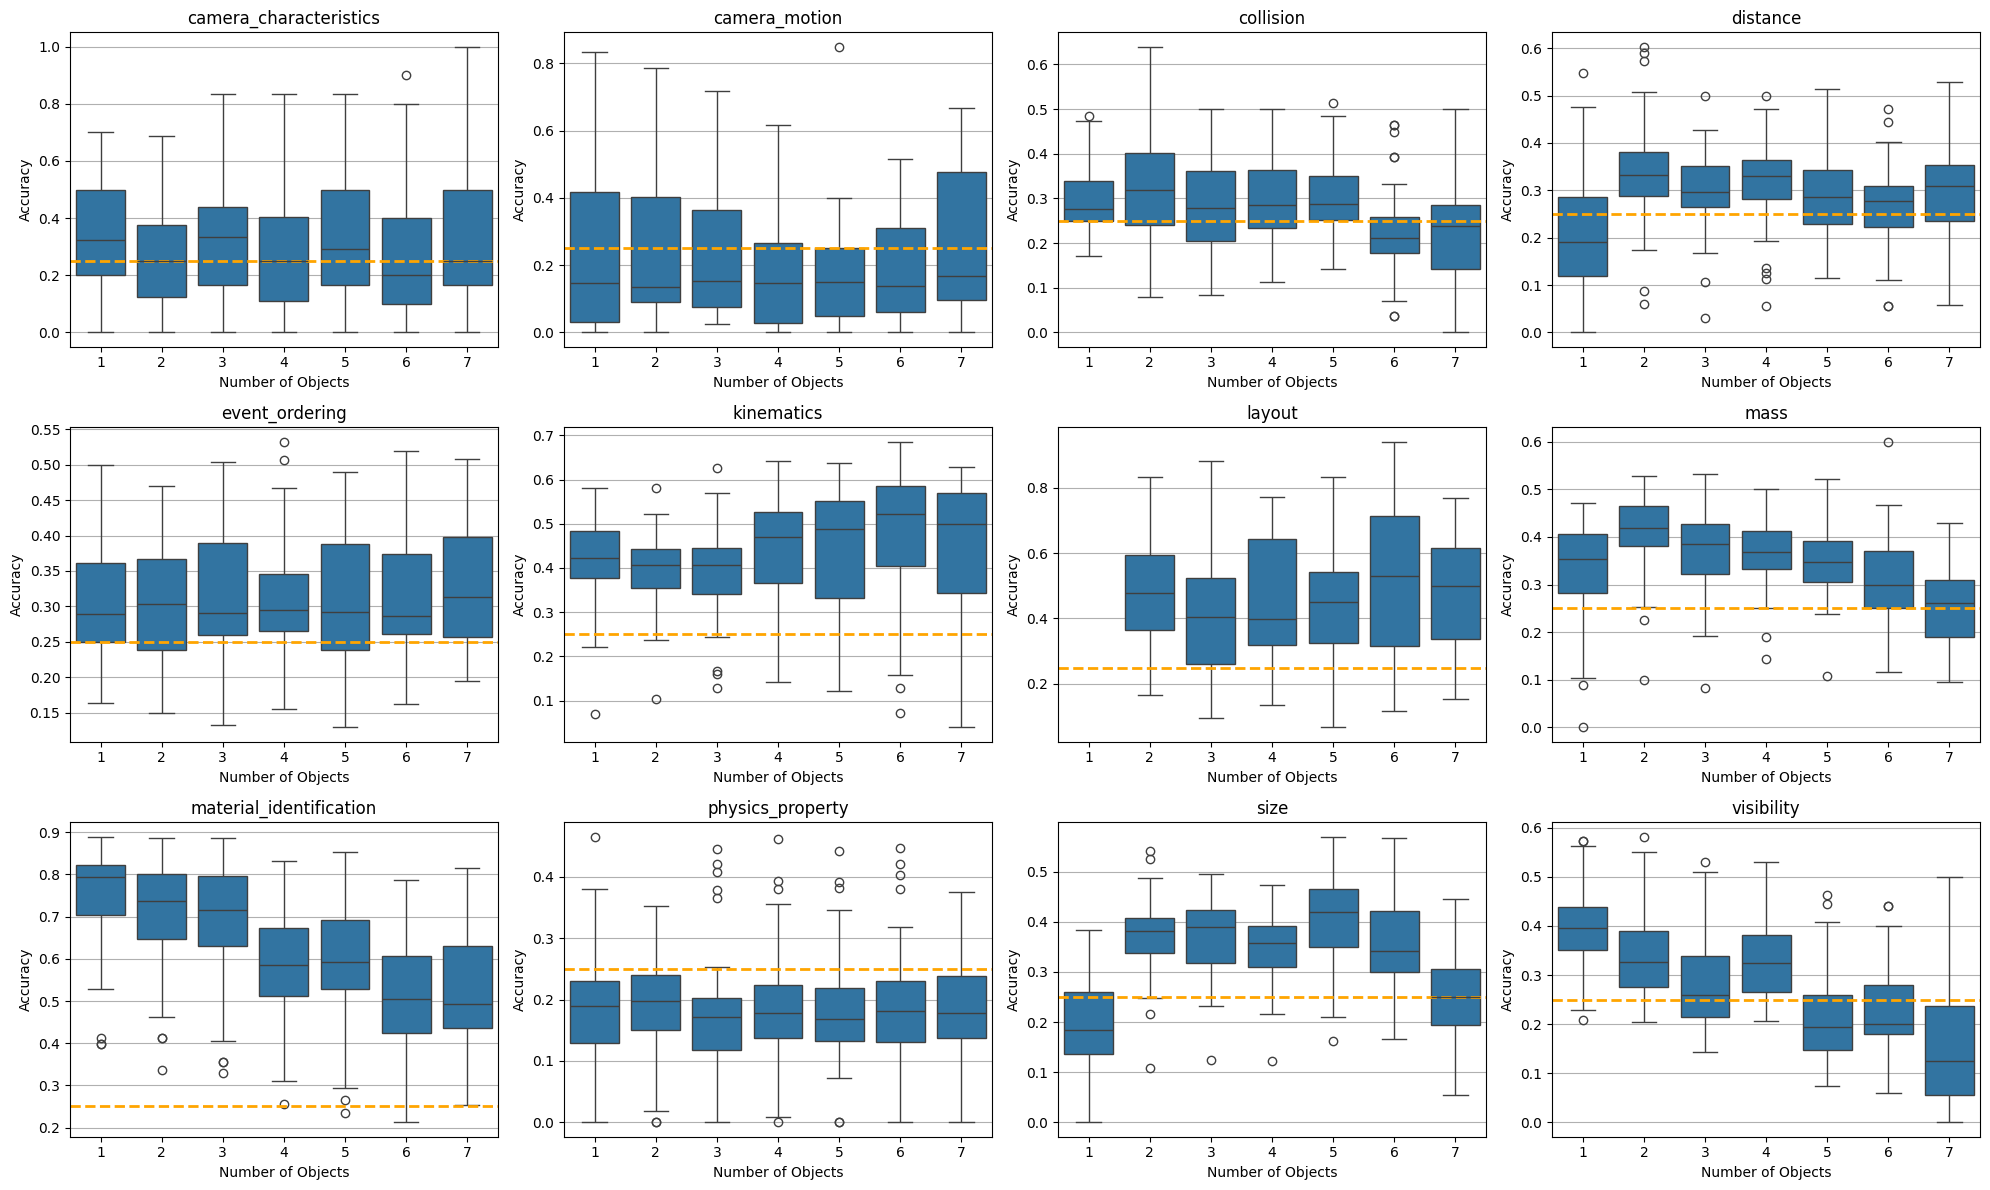

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

sub_categories = new_eval_per_subcat["sub_category"].unique()
n = len(sub_categories)
cols = 4
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
axes = axes.flatten()

for i, cat in enumerate(sub_categories):
    ax = axes[i]
    df_cat = new_eval_df[new_eval_df["sub_category"] == cat]
    sns.boxplot(data=df_cat, x="num_objects", y="accuracy", ax=ax)
    ax.axhline(y=0.25, color="orange", linestyle="--", linewidth=2, label=f"y={0.25:.2f}")
    ax.set_title(cat)
    ax.set_xlabel("Number of Objects")
    ax.set_ylabel("Accuracy")    
    ax.grid(axis='y')

# hide unused axes
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


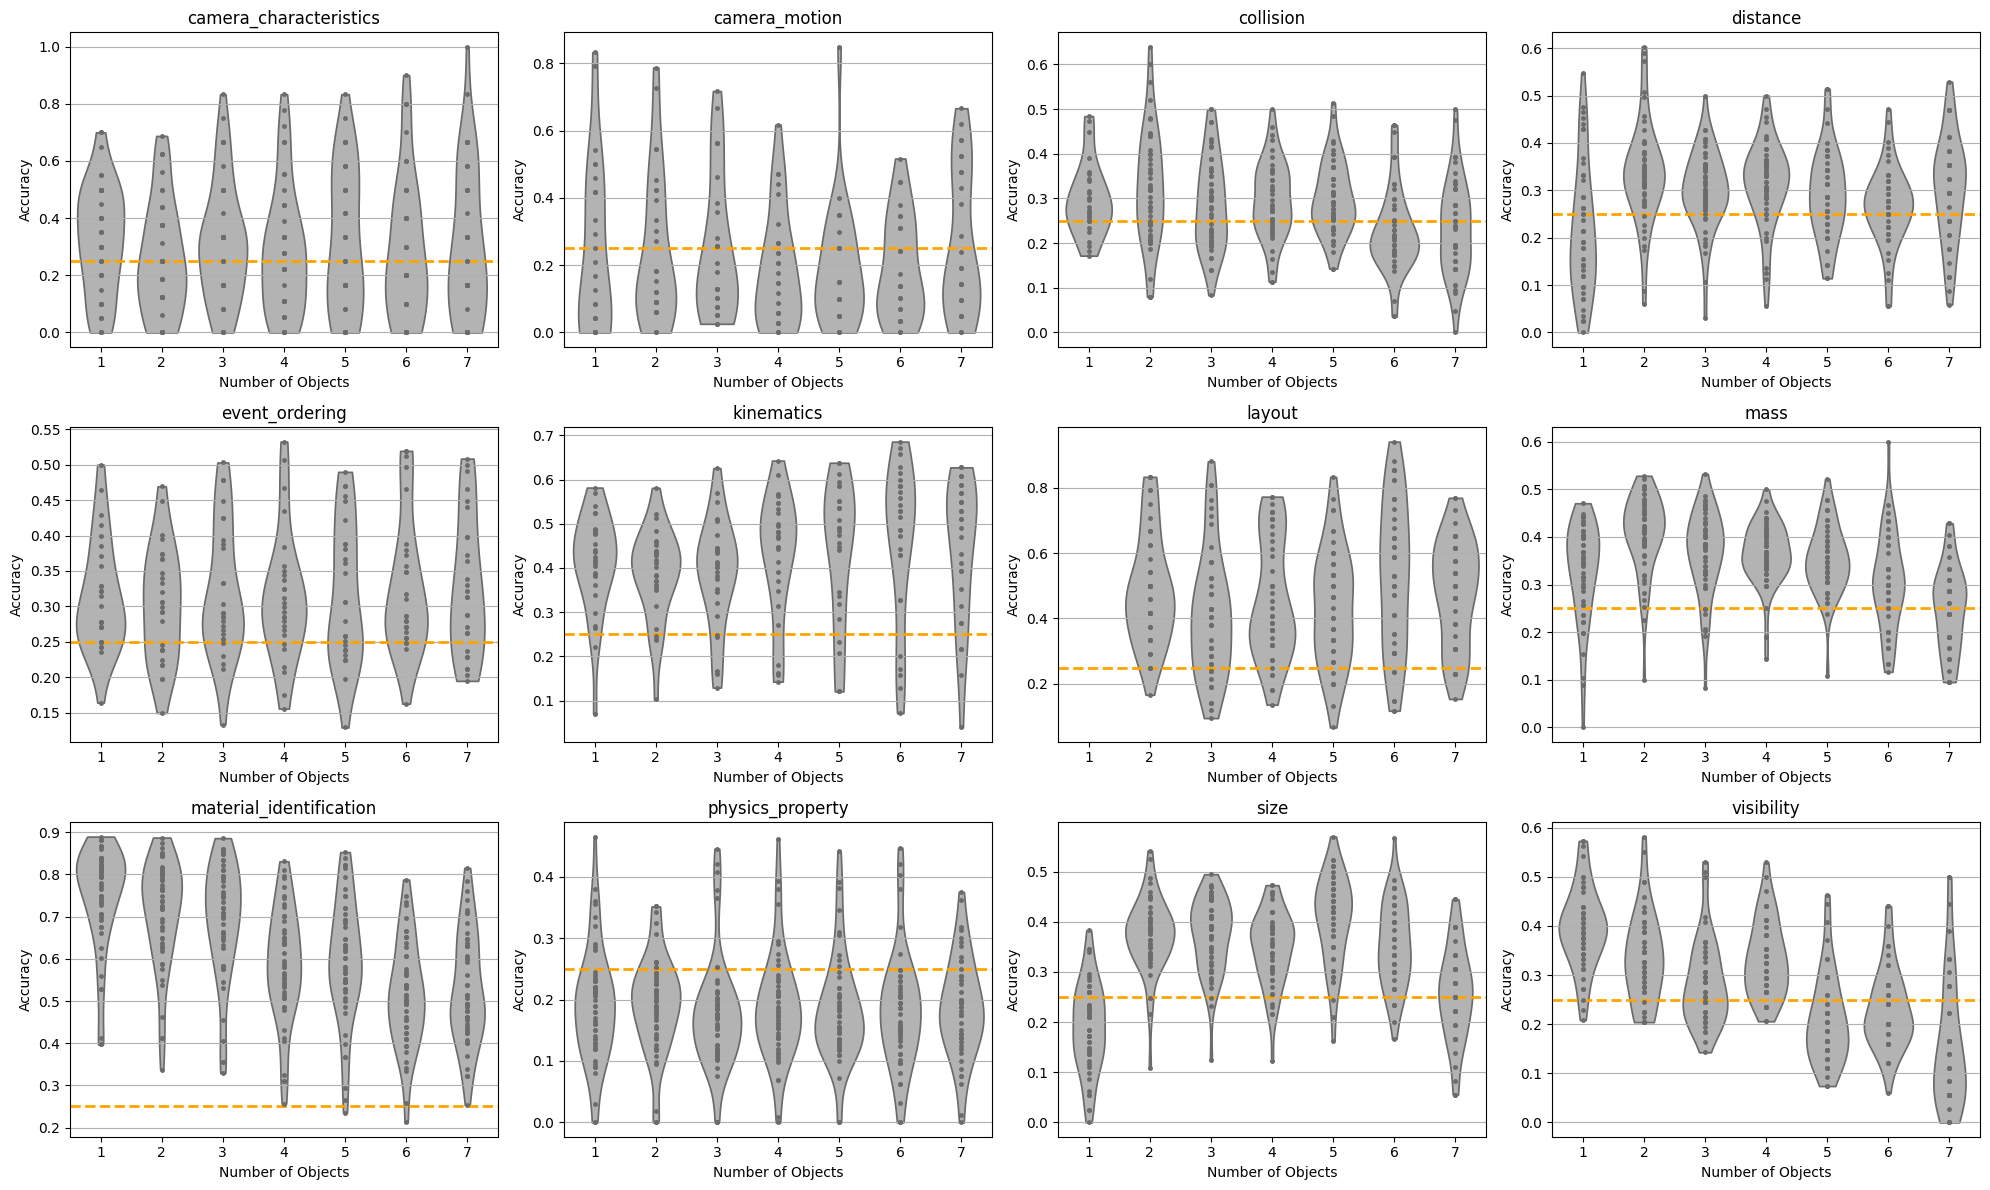

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

sub_categories = new_eval_per_subcat["sub_category"].unique()
n = len(sub_categories)
cols = 4
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
axes = axes.flatten()

for i, cat in enumerate(sub_categories):
    ax = axes[i]
    df_cat = new_eval_df[new_eval_df["sub_category"] == cat]
    sns.violinplot(
        data=df_cat,
        x="num_objects",
        y="accuracy",
        ax=ax,
        color="0.7",
        inner='point',
        cut=0,
    )
    ax.axhline(y=0.25, color="orange", linestyle="--", linewidth=2, label=f"y={0.25:.2f}")
    ax.set_title(cat)
    ax.set_xlabel("Number of Objects")
    ax.set_ylabel("Accuracy")    
    ax.grid(axis='y')

# hide unused axes
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

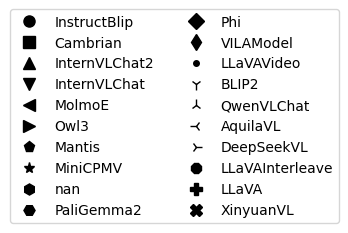

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(3, 1))

# Loop over markers and labels
for marker, label in zip(families_markers, families):
    plt.plot([], [], marker, color='black', label=label, markersize=8)

plt.legend(loc='center', ncol=2)
plt.axis('off')

plt.savefig(f"{plots_dir}/families.png", dpi=300, bbox_inches="tight")


plt.show()

/tmp/ipykernel_3343059/1273363072.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for model, df_m in df_cat.groupby("model_id"):
/tmp/ipykernel_3343059/1273363072.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for model, df_m in df_cat.groupby("model_id"):
/tmp/ipykernel_3343059/1273363072.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for model, df_m in df_cat.groupby("model_id"):
/tmp/ipykernel_3343059

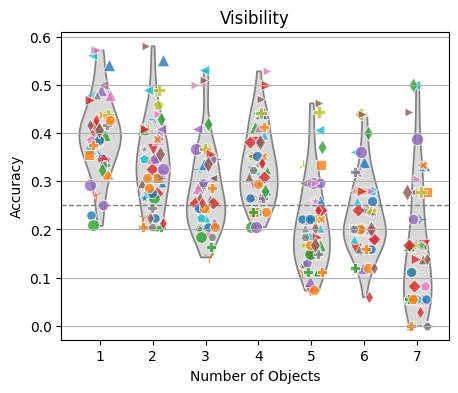

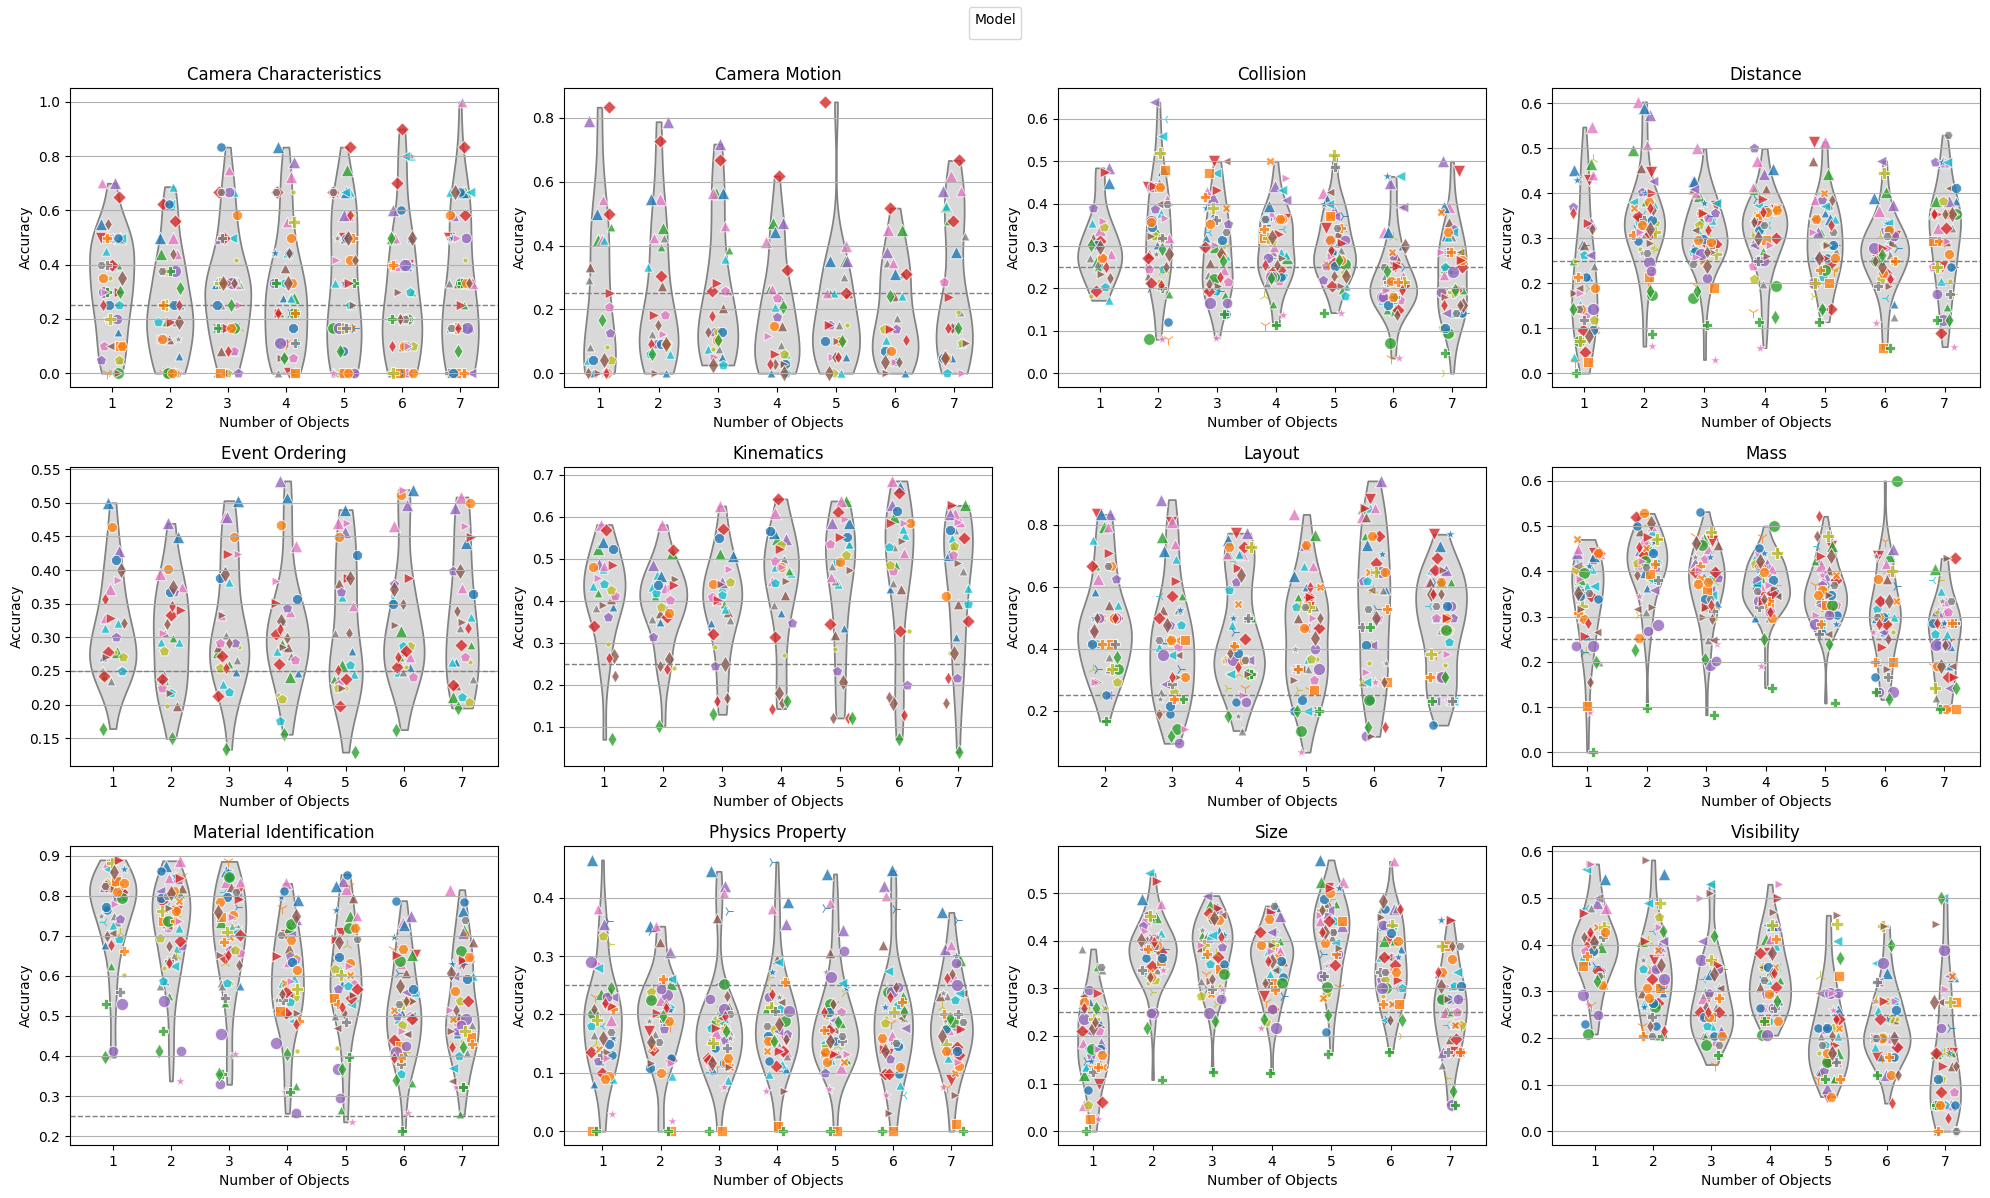

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import math
import warnings
warnings.filterwarnings("ignore", message=".*edgecolor.*unfilled marker.*")


sub_categories = new_eval_per_subcat["sub_category"].unique()
n = len(sub_categories)
cols = 4
rows = math.ceil(n / cols)

fig_single = plt.figure(figsize=(5, 4))

fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
axes = axes.flatten()

for i, cat in enumerate(sub_categories):
    ax = axes[i]
    df_cat = new_eval_df[new_eval_df["sub_category"] == cat]
    
    fig_single.clf()

    # same-colored violin
    for _ax in [ax, fig_single.gca()]:
        sns.violinplot(
            data=df_cat,
            x="num_objects",
            y="accuracy",
            ax=_ax,
            color="0.85",
            inner=None,
            cut=0
        )
        _ax.axhline(y=0.25, color="gray", linestyle="--", linewidth=1)

    # colored points by model_id
    for model, df_m in df_cat.groupby("model_id"):
        if df_m.shape[0] == 0:
            continue
        
        x_vals = pd.to_numeric(df_m["num_objects"], errors="coerce")
        y_vals = pd.to_numeric(df_m["accuracy"], errors="coerce")
        valid = (~x_vals.isna()) & (~y_vals.isna())
        
        # add horizontal jitter
        jitter = np.random.uniform(-0.2, 0.2, size=valid.sum())
        x_jittered = x_vals[valid] - 1 + jitter

        # print(model)
        color, marker, size = model_style.get(model)
        
        for _ax in [ax, fig_single.gca()]:
            _ax.scatter(
                x_jittered,
                # x_vals[valid]-1,
                y_vals[valid],
                color=color,
                label=model if i == 0 else None,
                s=40+40*size,
                alpha=0.8,
                edgecolor="white",
                linewidth=0.7,
                marker=marker
            )
    
    cat_name = mapping_sub[str(cat)]
    for _ax in [ax, fig_single.gca()]:
        _ax.set_title(cat_name)
        _ax.set_xlabel("Number of Objects")
        _ax.set_ylabel("Accuracy")
        _ax.grid(axis='y')
    
    fig_single.savefig(f"{plots_dir}/numobj_{cat}.png", dpi=300, bbox_inches="tight")

# remove empty axes
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

# global legend (only once)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, title="Model", loc="upper center", ncol=5)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [8]:
eval_df_multi_image = eval_df[eval_df['idx'].str.contains('_g')]
test = eval_df_multi_image.groupby(["model_id","sub_category"]).agg(accuracy=("is_correct", "mean")).reset_index()
test


/tmp/ipykernel_3303939/1858159134.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  test = eval_df_multi_image.groupby(["model_id","sub_category"]).agg(accuracy=("is_correct", "mean")).reset_index()


,model_id,sub_category,accuracy
0,Aquila-VL-2B,camera_characteristics,NaN
1,Aquila-VL-2B,camera_motion,NaN
2,Aquila-VL-2B,collision,NaN
3,Aquila-VL-2B,distance,NaN
4,Aquila-VL-2B,event_ordering,NaN
...,...,...,...
643,vila-1.5-8b,mass,0.190000
644,vila-1.5-8b,material_identification,0.208000
645,vila-1.5-8b,physics_property,0.142667
646,vila-1.5-8b,size,0.206000


/tmp/ipykernel_3303939/3006433228.py:25: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


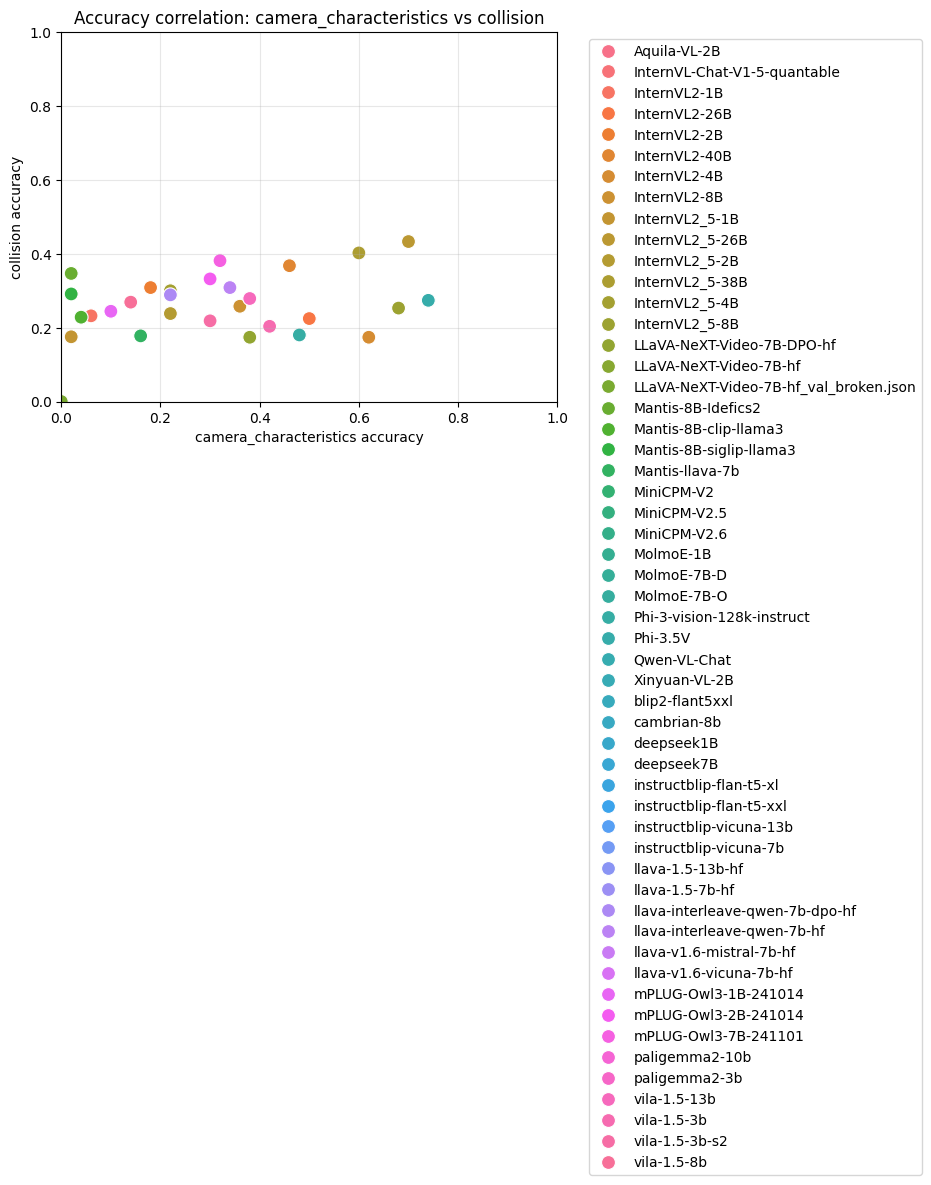

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Example input: model_id | sub_category | accuracy
# Pivot so each sub_category becomes a column
pivot = test.pivot(index="model_id", columns="sub_category", values="accuracy")

# Pick two subcategories to compare
x_cat = "camera_characteristics"
y_cat = "collision"   # change this to whatever category you want

# Drop rows with NaN in either column
df_plot = pivot[[x_cat, y_cat]].dropna().reset_index()

# Scatterplot comparing the two categories
sns.scatterplot(data=df_plot, x=x_cat, y=y_cat, hue="model_id", s=100)
plt.title(f"Accuracy correlation: {x_cat} vs {y_cat}")
plt.xlabel(f"{x_cat} accuracy")
plt.ylabel(f"{y_cat} accuracy")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr

# Pivot to wide format
pivot = test.pivot(index="model_id", columns="sub_category", values="accuracy").dropna(how="all")

# Build custom grid
sns.set(style="whitegrid")
g = sns.PairGrid(pivot, corner=True)
g.map_lower(sns.regplot, scatter_kws={'s': 50, 'alpha': 0.8, 'edgecolor': 'w'}, line_kws={'color': 'red', 'lw': 1.5})

# Add correlation coefficient to each lower subplot
for i, j in zip(*np.tril_indices_from(g.axes, -1)):
    ax = g.axes[i, j]
    x = pivot.iloc[:, j]
    y = pivot.iloc[:, i]
    mask = ~(x.isna() | y.isna())
    if mask.sum() > 1:
        r, _ = pearsonr(x[mask], y[mask])
        ax.text(0.05, 0.9, f"r={r:.2f}", transform=ax.transAxes, fontsize=9, color='red')

# Set axis limits and grid
for ax in g.axes.flatten():
    if ax is not None:        
        ax.grid(alpha=0.3, linewidth=0.5)

# Add clean borders
for ax_row in g.axes:
    for ax in ax_row:
        if ax is not None:
            for spine in ax.spines.values():
                spine.set_visible(True)
                spine.set_color("lightgray")

g.fig.suptitle("Pairwise Sub-Category Accuracy Correlations with Regression Lines", y=1.02)
plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'scipy'

In [ ]:
eval_df_multi_image = eval_df[eval_df['idx'].str.contains('_g')]
test_category = eval_df_multi_image.groupby(["model_id","category"]).agg(accuracy=("is_correct", "mean")).reset_index()
test_category


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr

# Pivot to wide format
pivot = test_category.pivot(index="model_id", columns="category", values="accuracy").dropna(how="all")

# Build custom grid
sns.set(style="whitegrid")
g = sns.PairGrid(pivot, corner=True)
g.map_lower(sns.regplot, scatter_kws={'s': 50, 'alpha': 0.8, 'edgecolor': 'w'}, line_kws={'color': 'red', 'lw': 1.5})

# Add correlation coefficient to each lower subplot
for i, j in zip(*np.tril_indices_from(g.axes, -1)):
    ax = g.axes[i, j]
    x = pivot.iloc[:, j]
    y = pivot.iloc[:, i]
    mask = ~(x.isna() | y.isna())
    if mask.sum() > 1:
        r, _ = pearsonr(x[mask], y[mask])
        ax.text(0.05, 0.9, f"r={r:.2f}", transform=ax.transAxes, fontsize=9, color='red')

# Set axis limits and grid
for ax in g.axes.flatten():
    if ax is not None:        
        ax.grid(alpha=0.3, linewidth=0.5)

# Add clean borders
for ax_row in g.axes:
    for ax in ax_row:
        if ax is not None:
            for spine in ax.spines.values():
                spine.set_visible(True)
                spine.set_color("lightgray")

g.fig.suptitle("Pairwise Sub-Category Accuracy Correlations with Regression Lines", y=1.02)
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib
import numpy as np

from matplotlib.colors import LinearSegmentedColormap

colors_balanced = ["#E57373", "#F6E6B3", "#8BC87A"]
cmap_balanced = LinearSegmentedColormap.from_list("soft_r2g", colors_balanced)

def gradient_box_word(word, cmap_name="RdYlGn_r"):
    cmap = matplotlib.cm.get_cmap(cmap_name)
    n = len(word)
    colors = [matplotlib.colors.rgb2hex(cmap(i/(n-1))) for i in range(n)]
    parts = []
    for ch, c in zip(word, colors):
        text_color = "white" if matplotlib.colors.rgb_to_hsv(matplotlib.colors.to_rgb(c))[2] < 0.5 else "black"
        parts.append(
            f"\\colorbox[HTML]{{{c[1:].upper()}}}{{\\strut\\textnormal{{\\textcolor{{{text_color}}}{{{ch}}}}}}}"
        )
    return "".join(parts)

worst_to_best_code = gradient_box_word("worst to best", cmap_name=cmap_balanced)


In [ ]:
# just changing the category for the sub_category of material_identification
eval_df["category"] = eval_df["category"].cat.add_categories(["visual_perception"])
eval_df.loc[eval_df["sub_category"] == "material_identification", "category"] = "visual_perception"

# Mid range: per sub_category

In [ ]:
eval_df_multi_image = eval_df[eval_df['idx'].str.contains('_i')]

acc_mat, _ = create_graph_from_eval_balanced(
    eval_base=eval_df_multi_image,                     # your row-level eval with is_correct
    index_to_use="sub_category",
    title="Balanced accuracy by sub_category and model - single-image",
    color_by_mode=True
)

In [ ]:
acc_mat

In [ ]:
eval_df_multi_image = eval_df[eval_df['idx'].str.contains('_g')]

acc_mat, _ = create_graph_from_eval_balanced(
    eval_base=eval_df_multi_image,                     # your row-level eval with is_correct
    index_to_use="sub_category",
    title="Balanced accuracy by sub_category and model - multi-image",
    color_by_mode=True
)

In [ ]:


# This will be in the supplementary material
acc_safe = acc_mat.apply(pd.to_numeric, errors="coerce").fillna(0).T
acc_safe.columns = [mapping_sub.get(col, col) for col in acc_safe.columns]
acc_safe.reset_index(inplace=True)
acc_safe = pd.concat([acc_safe.drop(0), acc_safe.loc[0:0]], ignore_index=True)
# use only 2 digits
acc_safe = acc_safe.round(4)

sub_categories = acc_safe.columns.tolist()
categories = [mapping_cat.get(mapping_sub_cat_name.get(col, col)) for col in sub_categories] 
acc_safe.columns = pd.MultiIndex.from_arrays([categories, sub_categories])

acc_safe = acc_safe.reindex(columns=pd.MultiIndex.from_tuples(
    sorted(acc_safe.columns, key=lambda x: categories.index(x[0]) if x[0] in categories else len(categories), reverse=True)
))

# drop index column
acc_safe.set_index(acc_safe.columns[0], inplace=True)

styled = acc_safe.style.background_gradient(cmap=cmap_balanced, axis=None, vmin=0, vmax=1)
styled.format(precision=4 )
latex_code = styled.to_latex(convert_css=True, position_float="centering", hrules=True, multirow_align="t", column_format="|l|c|c|cc|ccc|cc|cc|cc|", multicol_align="c|")

string_to_add_beginning = """
\\begin{table}[h]
\\centering
\\resizebox{\\textwidth}{!}{
"""

string_to_add_end = """
\\caption{
Balanced accuracy by sub-category and model - multi-image task.
For clarity, we color-code the results from {\\normalfont \\colorbox[HTML]{E57373}{\\strut\\textnormal{\\textcolor{black}{w}}}\\colorbox[HTML]{E8867E}{\\strut\\textnormal{\\textcolor{black}{o}}}\\colorbox[HTML]{EB9988}{\\strut\\textnormal{\\textcolor{black}{r}}}\\colorbox[HTML]{EEAD93}{\\strut\\textnormal{\\textcolor{black}{s}}}\\colorbox[HTML]{F0C09E}{\\strut\\textnormal{\\textcolor{black}{t}}}\\colorbox[HTML]{F3D3A8}{\\strut\\textnormal{\\textcolor{black}{ }}}\\colorbox[HTML]{F6E6B3}{\\strut\\textnormal{\\textcolor{black}{t}}}\\colorbox[HTML]{E4E1A9}{\\strut\\textnormal{\\textcolor{black}{o}}}\\colorbox[HTML]{D2DCA0}{\\strut\\textnormal{\\textcolor{black}{ }}}\\colorbox[HTML]{C0D796}{\\strut\\textnormal{\\textcolor{black}{b}}}\\colorbox[HTML]{AED28D}{\\strut\\textnormal{\\textcolor{black}{e}}}\\colorbox[HTML]{9DCD83}{\\strut\\textnormal{\\textcolor{black}{s}}}\\colorbox[HTML]{8BC87A}{\\strut\\textnormal{\\textcolor{black}{t}}}}.
}
\\end{table}
"""

string_to_substitute = """
\\multirow{2}{*}{model\\_id} & 
\\multicolumn{9}{c}{\\textbf{Evaluation Categories}} & 
\\multirow{}{}{\\textbf{Total}} \\
\\cmidrule(lr){2-10}
"""

total_code = latex_code.replace("\\begin{table}\n\\centering", string_to_add_beginning).replace("\\end{tabular}\n\\end{table}", "\\end{tabular}\n}") + string_to_add_end

# replace for multirow and multicolumn
total_code = total_code.replace("(nan, 'model_id') &  &  &  &  &  &  &  &  &  &  &  &  &  \\\\", "")
total_code = total_code.replace("nan", "")
total_code = total_code.replace("& Total &", "\\midrule \n VLM Model & Average per Model &")
total_code = total_code.replace("Average & ", "\\midrule \nAverage per Task & ")
total_code = total_code.replace("\\multicolumn{2}{r}{nan}", "\\multicolumn{2}{c}{}")
total_code = total_code.replace("Material Identification", "\\makecell{Material \\\\ Identification}")
total_code = total_code.replace("Camera Characteristics", "\\makecell{Camera \\\\ Characteristics}")
total_code = total_code.replace("Physics Property", "\\makecell{Physics \\\\ Property}")

# total_code = latex_code.replace("\\begin{table}\n\\centering", string_to_add_beginning).replace("\\toprule", string_to_substitute).replace("\\end{tabular}\n\\end{table}", "\\end{tabular}\n}") + string_to_add_end

print(total_code)


In [ ]:
import matplotlib
import numpy as np

def gradient_box_word(word, cmap_name="RdYlGn_r"):
    cmap = matplotlib.cm.get_cmap(cmap_name)
    n = len(word)
    colors = [matplotlib.colors.rgb2hex(cmap(i/(n-1))) for i in range(n)]
    parts = []
    for ch, c in zip(word, colors):
        text_color = "white" if matplotlib.colors.rgb_to_hsv(matplotlib.colors.to_rgb(c))[2] < 0.5 else "black"
        parts.append(f"\\colorbox[HTML]{{{c[1:].upper()}}}{{\\textcolor{{{text_color}}}{{{ch}}}}}")
    return "".join(parts)

gradient_box_word("worst and best", cmap_name="RdYlGn")


In [ ]:
import matplotlib
import numpy as np

def gradient_word(word, cmap_name="RdYlGn_r", n=None):
    cmap = matplotlib.cm.get_cmap(cmap_name)
    n = n or len(word)
    colors = [matplotlib.colors.rgb2hex(cmap(i/(n-1))) for i in range(n)]
    parts = [
        f"\\textcolor[HTML]{{{c[1:].upper()}}}{{{ch}}}"
        for ch, c in zip(word, colors)
    ]
    return "".join(parts)

colored_text = gradient_word("worst and best", cmap_name="RdYlGn_r")
print(colored_text)

In [ ]:

acc_safe = acc_mat.apply(pd.to_numeric, errors="coerce").fillna(0).T
acc_safe.head()
# rename columns to be more LaTeX friendly
acc_safe.columns = ["Material Understanding", "Mechanics", "Spatial Reasoning", "View Point", "Visual Perception", "Total"]
styled = acc_safe.style.background_gradient(cmap="RdYlGn", axis=None)
latex_code = styled.to_latex(convert_css=True)
print(latex_code)

# acc_safe = acc_mat.apply(pd.to_numeric, errors="coerce").fillna(0)
# styled = acc_safe.T.style.background_gradient(cmap="RdYlGn", axis=None)
# latex_code = styled.to_latex(convert_css=True)

# Highest 

In [ ]:
eval_df_multi_image = eval_df[eval_df['idx'].str.contains('_g')]

acc_mat, _ = create_graph_from_eval_balanced(
    eval_base=eval_df_multi_image,                     # your row-level eval with is_correct
    index_to_use="category",
    title="Balanced accuracy by category and model - multi-image",
    color_by_mode=True
)

In [ ]:
eval_df_multi_image = eval_df[eval_df['idx'].str.contains('_i')]

acc_mat, _ = create_graph_from_eval_balanced(
    eval_base=eval_df_multi_image,                     # your row-level eval with is_correct
    index_to_use="category",
    title="Balanced accuracy by category and model - single-image",
    color_by_mode=True
)

In [ ]:

acc_safe = acc_mat.apply(pd.to_numeric, errors="coerce").fillna(0).T
acc_safe.head()
# rename columns to be more LaTeX friendly
acc_safe.columns = ["Material Understanding", "Mechanics", "Spatial Reasoning", "View Point", "Visual Perception", "Total"]
styled = acc_safe.style.background_gradient(cmap="RdYlGn", axis=None)
latex_code = styled.to_latex(convert_css=True)
print(latex_code)

# acc_safe = acc_mat.apply(pd.to_numeric, errors="coerce").fillna(0)
# styled = acc_safe.T.style.background_gradient(cmap="RdYlGn", axis=None)
# latex_code = styled.to_latex(convert_css=True)

In [ ]:
acc_mat.iloc[-1:, :]

In [ ]:
# Export to LaTeX with color commands
# # Apply red→green gradient
# styled = acc_mat.T.style.background_gradient(
#     subset=acc_mat.columns,
#     cmap="RdYlGn"  # Red → Yellow → Green
# )

# # Export to LaTeX with color commands
# latex_code = styled.to_latex(convert_css=True)

# print(latex_code)

In [ ]:
# import common sense values
import json

with open('./utils/common_sense.json', 'r') as file:
    common_sense_df = pd.DataFrame(json.load(file))

common_sense_df.head()

model_unique_ids = eval_df['model_id'].unique()

common_sense_accuracy = {}

for model_id in model_unique_ids:
    for cs_model_id in common_sense_df['Method'].values:
        modified_model_id = model_id
        if "2_5" in model_id:
            modified_model_id = model_id.replace("2_5", "2.5")
        if modified_model_id in cs_model_id:
            # print(f"Model: {modified_model_id}, Common Sense Score: {cs_model_id}")
            common_sense_accuracy[model_id] = common_sense_df[common_sense_df['Method'] == cs_model_id]['Avg. Score'].values[0]

print(common_sense_accuracy)


In [ ]:
from matplotlib.colors import LogNorm

accuracy_total_per_model = acc_mat.iloc[-1:, :]
eval_df_accuracy_total_per_model = eval_df.merge(
    accuracy_total_per_model.T.reset_index().rename(columns={0: 'balanced_accuracy'}),
    left_on='model_id',
    right_on='model_id',
    how='left'
).groupby('model_id').first().reset_index()[['model_id', 'Total', 'mode_y', 'params_b']].rename(columns={'Total': 'balanced_accuracy', 'mode_y': 'mode'}).merge(
    pd.DataFrame.from_dict(common_sense_accuracy, orient='index', columns=['common_sense_accuracy']).reset_index().rename(columns={'index': 'model_id'}),
    on='model_id',
    how='left'
).dropna(subset=['common_sense_accuracy'])
eval_df_accuracy_total_per_model["common_sense_accuracy"] = (
    pd.to_numeric(eval_df_accuracy_total_per_model["common_sense_accuracy"], errors="coerce")
)

eval_df_accuracy_total_per_model.head(50)


In [ ]:
plt.figure(figsize=(12, 6))

num_cols = ["common_sense_accuracy", "balanced_accuracy", "params_b"]
for c in num_cols:
    eval_df_accuracy_total_per_model[c] = pd.to_numeric(
        eval_df_accuracy_total_per_model[c], errors="coerce"
    ).astype(float)

sns.regplot(
    data=eval_df_accuracy_total_per_model,
    x="common_sense_accuracy",
    y="balanced_accuracy",
    scatter=False,
    ci=95,
    line_kws={"color": "red", "lw": 1.5, "ls": "--"}
)

ax = sns.scatterplot(
    data=eval_df_accuracy_total_per_model,
    x="common_sense_accuracy",
    y="balanced_accuracy",
    hue="mode",
    size="params_b",
    sizes=(40, 900),
    size_norm=LogNorm(),   # params_b must be > 0
    marker="o",
    edgecolor="w",
    alpha=0.9,
    legend=False
)

# keep accuracy linear
ax.set_xlabel("Common Sense Accuracy")
ax.set_ylabel("Mean Accuracy (LoFi)")
ax.set_title("LoFi Accuracy vs AVG. 8 Multimodal benchmarks, Colored by Mode")
ax.grid(alpha=0.3, which="both", axis="x")

df_plot = eval_df_accuracy_total_per_model.query(
    "mode_clean in ['single-frame', 'multi-frame']"
).copy()
# choose palette and order
hue_order = ["single-frame", "multi-frame"]
palette = dict(zip(hue_order, sns.color_palette(n_colors=len(hue_order))))
# manual color-only legend
from matplotlib.lines import Line2D
present = [k for k in hue_order if k in set(df_plot["mode_clean"])]
handles = [Line2D([0],[0], marker="o", linestyle="", color=palette[k], label=k) for k in present]
ax.legend(handles=handles, title="Model type", loc="best")

annotate_df = (
    eval_df_accuracy_total_per_model
    .dropna(subset=["common_sense_accuracy", "balanced_accuracy"])
    .sort_values("balanced_accuracy", ascending=False)
)
for _, r in annotate_df.iterrows():
    ax.annotate(
        r["model_id"],
        xy=(r["common_sense_accuracy"], r["balanced_accuracy"]),
        xytext=(5, 0),
        textcoords="offset points",
        va="center",
        fontsize=8
    )

plt.tight_layout()
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.regplot(
    data=eval_df_accuracy_total_per_model,
    x="common_sense_accuracy",
    y="balanced_accuracy",
    scatter=True,
    ci=95,         # confidence interval
    line_kws={"color": "red", "linewidth": 2}
)

corr = eval_df_accuracy_total_per_model["common_sense_accuracy"].corr(eval_df_accuracy_total_per_model["balanced_accuracy"])
plt.title(f"Correlation = {corr:.3f}")
plt.show()


In [ ]:
from scipy.stats import spearmanr
rho, _ = spearmanr(eval_df_accuracy_total_per_model["common_sense_accuracy"], eval_df_accuracy_total_per_model["balanced_accuracy"])
print(f"Spearman correlation: {rho:.3f}")


In [ ]:
import numpy as np

x = eval_df_accuracy_total_per_model["common_sense_accuracy"]
y = eval_df_accuracy_total_per_model["balanced_accuracy"]

# Fit regression line
m, b = np.polyfit(x, y, 1)
y_pred = m * x + b

# Residuals (errors)
residuals = y - y_pred

import seaborn as sns
sns.kdeplot(residuals, fill=True)
plt.title("Residual Density")
plt.xlabel("Residual")
plt.show()


In [ ]:
plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted values")
plt.xlabel("Predicted balanced accuracy")
plt.ylabel("Residual")
plt.show()


In [ ]:
import pandas as pd
print(pd.Series(residuals).describe())